In [1]:
import os

os.chdir('..')

In [2]:
import re
import json
import numpy as np
import pandas as pd

from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as patheffects

tqdm.pandas()
plt.style.use('../../groene.mpl')

%matplotlib inline
%config InlineBackend.figure_format='retina'

#DATA_PATH = '../../mc4_dutch/data/' # change this to data
DATA_PATH = 'data'

In [3]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=100):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=100, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

In [4]:
data = pd.read_csv(os.path.join(DATA_PATH, 'url_counts.csv'))

labels_corrected = json.loads(open(os.path.join(DATA_PATH, 'label_correction.json')).read())
translate_labels = {'Recreation': 'Recreatie',
                    'News': 'Nieuws en media',
                     'Reference': 'Naslag',
                     'Computers': 'Technologie',
                     'Home': 'Huis en tuin',
                     'Shopping': 'Winkelen',
                     'Business': 'Zakelijk',
                     'Society': 'Maatschappij',
                     'Health': 'Gezondheid',
                     'Arts': 'Kunst',
                     'Sports': 'Sport',
                     'Science': 'Wetenschap',
                     'Games': 'Games',
                     'Kids_and_Teens': 'Kinderen en tieners'}

data['Label'] = data.progress_apply(lambda d: labels_corrected[d['Url']] 
                                    if d['Url'] in labels_corrected else d['Label'], axis=1)
data['Label vertaald'] = data.Label.progress_apply(lambda x: translate_labels[x] 
                                                   if x in translate_labels else np.nan)

  0%|          | 0/2542277 [00:00<?, ?it/s]

  0%|          | 0/2542277 [00:00<?, ?it/s]

In [5]:
top_20 = data.iloc[0:20]

label2col = {'Recreatie': '#e30b1b',
 'Nieuws en media': '#127abf',
 'Naslag': '#e8d001',
 'Technologie': '#3c9535',
 'Huis en tuin': '#f39307',
 'Winkelen': '#db7aaf',
 'Zakelijk': '#BE4F00',
 'Maatschappij': '#7f7b7a',
 'Gezondheid': '#95a5a6',
 'Kunst': '#95a5a6',
 'Sport': '#95a5a6',
 'Wetenschap': '#95a5a6',
 'Games': '#95a5a6',
 'Kinderen en tieners': '#95a5a6'}

table_colors = list(top_20['Label vertaald'].apply(lambda x: label2col[x]).values)
top_20.columns = ['URL', 'Aantal woorden', '', 'Label', 'Aandeel', 'Label vertaald']

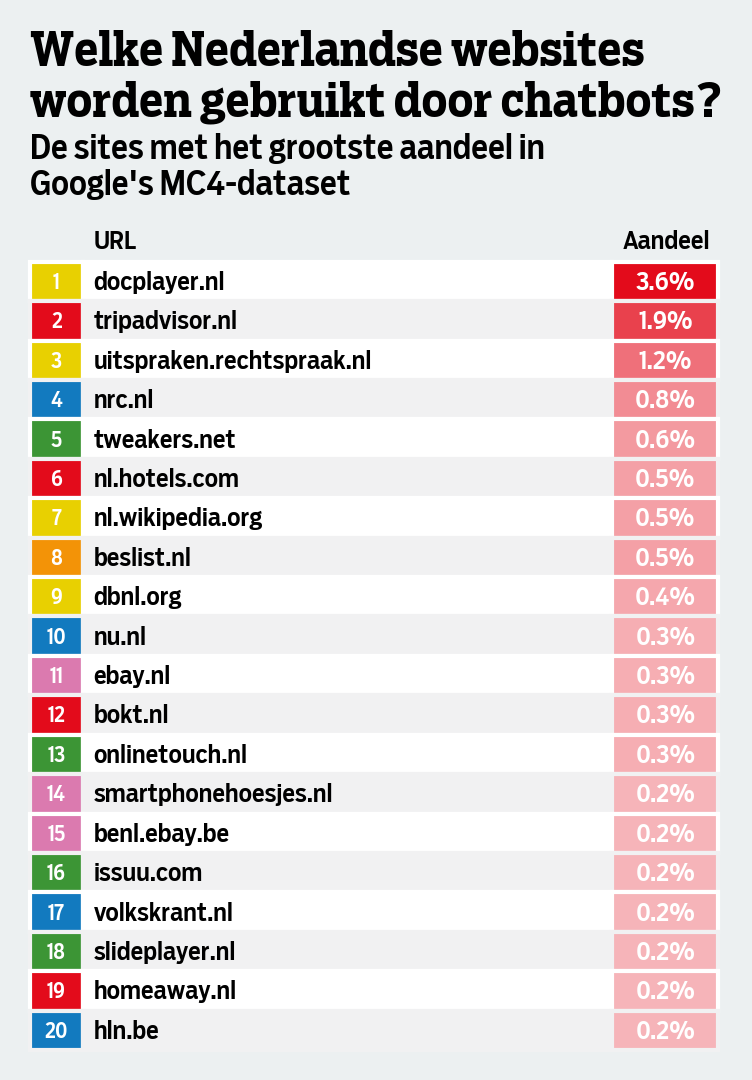

In [6]:
import six
import matplotlib as mpl

def render_mpl_table(data, colors, max_val=0, col_width=3.0, row_height=0.625, font_size=14, figsize=None,
                     header_color='#c71617', row_colors=['w','#f1f1f2'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, dpi=150)
    ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colWidths=[0.07, 0.7, 0.14],
                         colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    done_cells = []
    
    color = '#f1f1f2'
    for k, cell in six.iteritems(mpl_table._cells):
        
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='normal', color='black', ha='left')
            cell.set_facecolor('#ECF0F1')
            cell.set_edgecolor('#ECF0F1')
            cell.set_height(0.06
                           )
            if k[1] == 1:
                cell.PAD = 0.02
            if k[1] == 3:
                cell.set_text_props(ha='center')
            continue
        elif k[0]%2:
            cell.set_facecolor(row_colors[0])
            cell.set_edgecolor(row_colors[0])
        else:
            cell.set_facecolor(row_colors[1])
            cell.set_edgecolor(row_colors[1])
        if k[1] == 3:
            cell.set_text_props(ha='center')
        else:
            cell.set_text_props(ha='left', x=-10)
        if k[1] == 0:
            cell.set_facecolor(colors[k[0] - 1])
            cell.set_text_props(ha='center', fontsize=5, c='white')
            cell.PAD = 0
        if k[1] == 1:
            cell.PAD = 0.02
        if k[1] == 2:
            cell.set_text_props(ha='center', c='white')
            color = 0.25 + float(cell._text.get_text().replace('%', '')) / max_val
            cell.set_facecolor(cmap(color))
    return ax

cmap = mpl.colors.LinearSegmentedColormap.from_list('test', colors=['white','#e30b1b'])

fig, ax = plt.subplots(figsize=(5.299 / 2, 3.9), dpi=150)
render_mpl_table(top_20[['', 'URL', 'Aandeel']], colors=table_colors, 
                 font_size=6, ax=ax, max_val=3.6)

ax.set_title("Welke Nederlandse websites\nworden gebruikt door chatbots?", fontsize=11, 
             weight='extra bold', x=0, y=1.095,ha='left')        
ax.text(0, 1.03, 'De sites met het grootste aandeel in\nGoogle\'s MC4-dataset', fontsize=8)

set_size(fig, (5.299 / 2, 3.6), dpi=300)

fig.savefig('figures/1.pdf', dpi=300, bbox_inches='tight')

## Categories

In [7]:
def shorten_number(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format(round(num, 2), ['', 'K', ' mln.', ' mld.', 'T'][magnitude])

label_counts = data.groupby('Label vertaald').sum().sort_values('Aantal woorden', ascending=False)
label_counts['Number_string'] = label_counts['Aantal woorden'].apply(shorten_number)

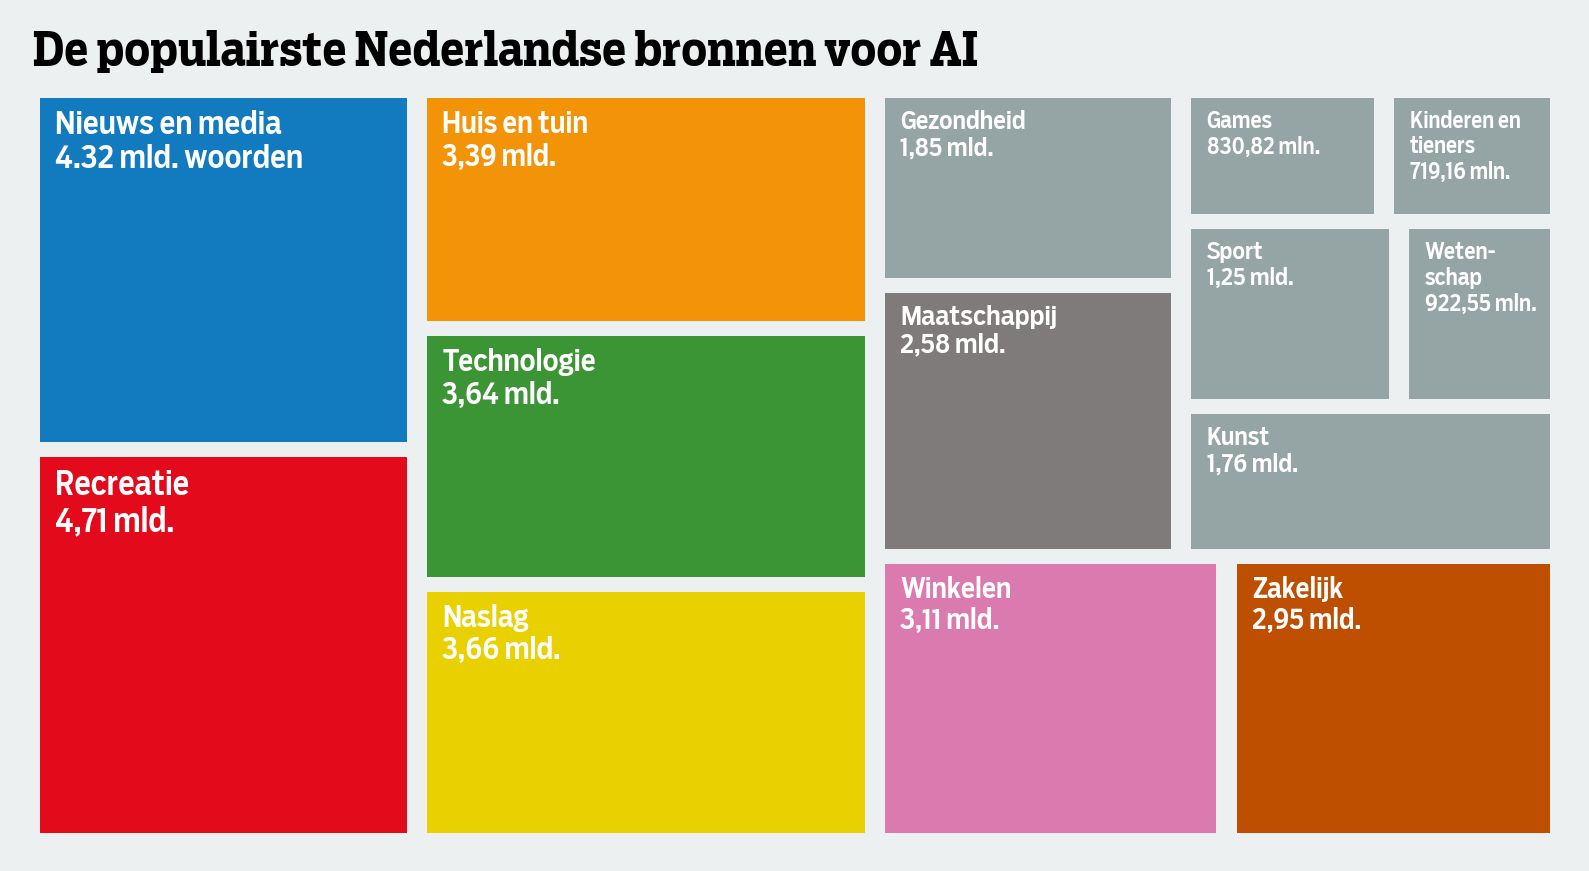

In [8]:
import squarify_custom

fig, ax = plt.subplots(figsize=(5.299, 2.53), dpi=150)

labels_to_plot = ['Recreatie', 'Nieuws en media', 'Naslag', 'Technologie', 'Huis en tuin',
       'Winkelen', 'Zakelijk', 'Maatschappij', 'Gezondheid', 'Kunst', 'Sport',
       'Weten-\nschap', 'Games', 'Kinderen en\ntieners']

squarify_custom.plot(
        sizes=label_counts['Aantal woorden'], pad=1, linewidth=10, loc='top left',
        label=[x + '\n' +  str(i).replace('.', ',', 1) if idx != 1 else x + '\n' +  str(i) + ' woorden'
               for idx, (x,i) in enumerate(zip(labels_to_plot, label_counts.Number_string))],
             color=[label2col[x] if x in label2col else '#7f7b7a' for x in label_counts.index], norm_x=150,
            text_kwargs={'wrap':True, 'color':'white'})

plt.axis("off")
plt.tight_layout()

plt.title('De populairste Nederlandse bronnen voor AI', x=0.002, ha='left', fontsize=11)
set_size(fig, (5.299, 2.9), dpi=300)

plt.savefig('figures/2.pdf', dpi=300, bbox_inches='tight')

In [9]:
vals = list(label_counts['Aantal woorden'].values)
labels = list(label_counts.index.values)

label_counts['Perc'] = round(label_counts['Aantal woorden'] / sum(label_counts['Aantal woorden']) * 100).astype(int)
percentages = label_counts.Perc.values

all_sub_mags = []
all_labels = []
for idx, label in enumerate(labels):
    N = 50
    top_n = data[(data['Label vertaald'] == label)].sort_values('Aantal woorden', ascending=False)
    top_n['rel'] = top_n['Aantal woorden'] / sum(top_n['Aantal woorden']) * 100
    sub_mags = list(top_n.head(N).rel.values) + [100 - sum(top_n.head(N).rel)]
    all_sub_mags.append(sub_mags)
    all_labels.append([x if i < (5 if idx < 5 else 2) else '' for i, x in enumerate(list(top_n.head(N).Url.values))])

In [ ]:
!pip install circlify

In [10]:
import circlify

circles = circlify.circlify(
    vals, 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

child_circle_groups = []
for i in range(len(vals)):
    child_circle_groups.append(circlify.circlify(
        all_sub_mags[::-1][i], 
        show_enclosure=False, 
        target_enclosure=circlify.Circle(x=circles[i].x, y=circles[i].y, r=circles[i].r)
    ))

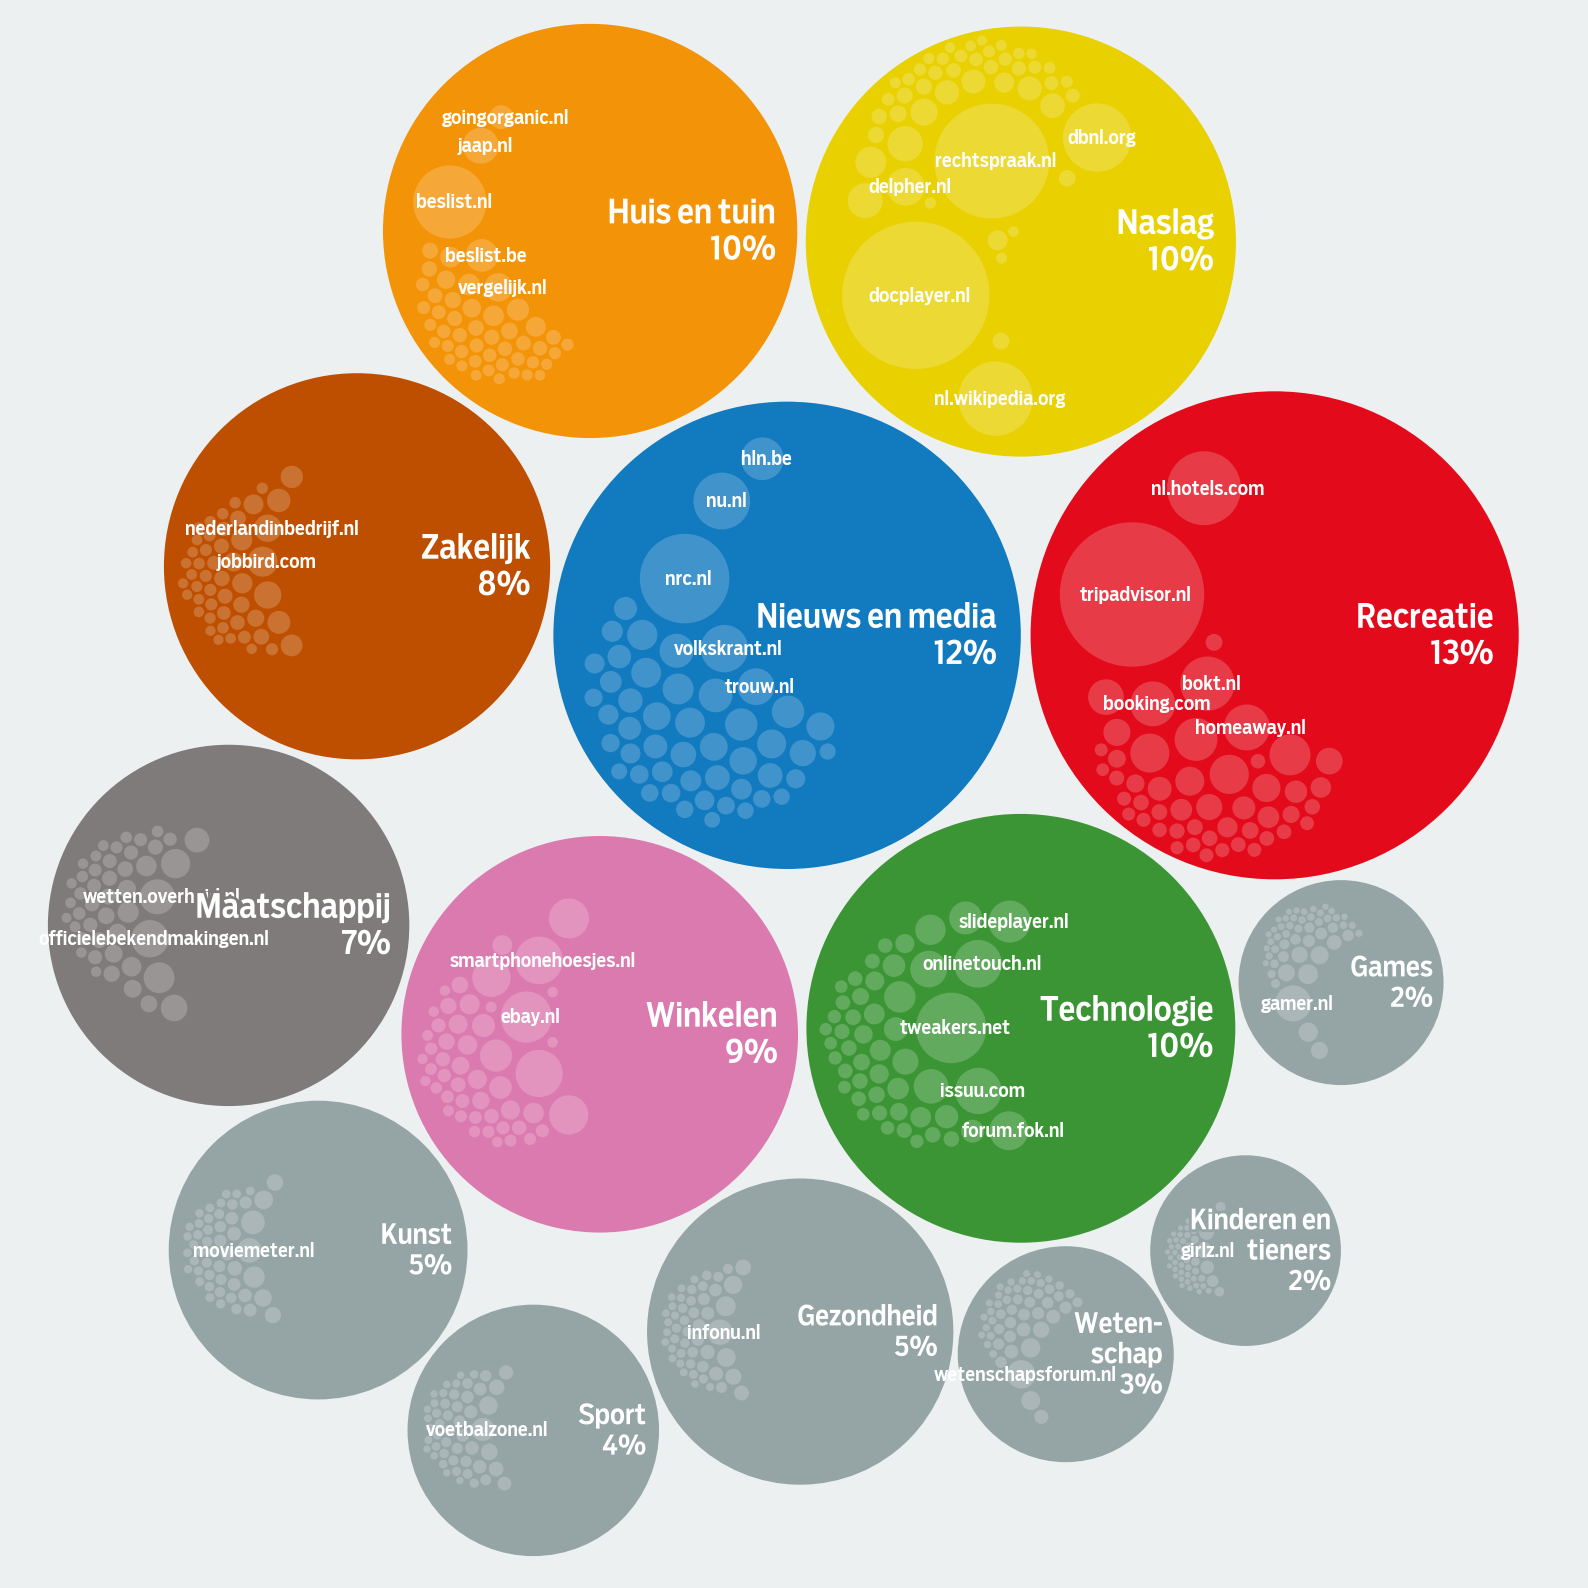

In [11]:
def trim_label(label):
    if len(label) > 20:
        label = '.'.join(label.split('.')[-2:])
    return label

fig, ax = plt.subplots(figsize=(10,7.94))

ax.axis('off')

lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)


for i, circle in enumerate(circles):
    if i > 12:
        plus = 0.20
        fontsize = 12
    elif i > 5:
        plus = 0.22
        fontsize = 12
    else:
        plus = 0.13
        fontsize = 10
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r * 0.98, alpha=1, linewidth=0, color=label2col[labels[::-1][i]])) 
    plt.text(x + (r * 0.88),y,labels_to_plot[::-1][i] + '\n  ' + str(percentages[::-1][i]) + '%'
             , fontsize=fontsize, color='white', zorder=100, ha='right', va='center', path_effects=
            [patheffects.withStroke(linewidth=2, foreground=label2col[labels[::-1][i]])])

for i, child_circles in enumerate(child_circle_groups):
    if i > 6:
        for idx, child_circle in enumerate(child_circles[:-1]):
            x, y, r = child_circle
            ax.add_patch(plt.Circle((x + 0.02, y), r * 0.85, alpha=0.2, linewidth=0, color='white')) 
            website_label = trim_label(all_labels[::-1][i][::-1][idx])
            plt.text(x + 0.025,y, website_label, 
                     color='white', fontsize=7, ha='center', va='center')
    
    elif i > 5:
        for idx, child_circle in enumerate(child_circles[:-1]):
            if idx < 4:
                continue
            x, y, r = child_circle
            ax.add_patch(plt.Circle((x + 0.02, y), r * 0.85, alpha=0.2, linewidth=0, color='white')) 
            website_label = trim_label(all_labels[::-1][i][::-1][idx])
            plt.text(x + 0.025,y, website_label , color='white', fontsize=7, ha='center', va='center')
            
    else:
        for idx, child_circle in enumerate(child_circles[:-1]):
            x, y, r = child_circle
            ax.add_patch(plt.Circle((x + 0.02, y), r * 0.85, alpha=0.2, linewidth=0, color='white')) 
            website_label = trim_label(all_labels[::-1][i][::-1][idx])
            if idx < len(child_circles) - 2:
                continue
            plt.text(x + 0.025,y, website_label , color='white', fontsize=7, ha='center', va='center')


        set_size(fig, (7.94, 7.94))
plt.savefig('figures/3.pdf', dpi=300, bbox_inches='tight')

## Compare GPT-3 filter

In [12]:
top_20_quality = pd.read_csv(os.path.join(DATA_PATH, 'quality_url_counts.csv')).head(20)
top_20_quality['Label'] = top_20_quality.progress_apply(lambda d: labels_corrected[d['Url']] 
                                                        if d['Url'] in labels_corrected else d['Label'], axis=1)
top_20_quality['Label vertaald'] = top_20_quality.Label.apply(lambda x: translate_labels[x])
top_20_quality.columns = ['URL', 'Aantal woorden', '', 'Verschil', 'Label', 'Aandeel', 'Label vertaald']

top_20['Verschil'] = 0

quality_col_labels = list(top_20_quality['Label vertaald'].apply(lambda x: label2col[x]).values)

  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/2k/7cd17ldj27z5wcn2t1m44tq00000gn/T/ipykernel_15313/3655277395.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_20['Verschil'] = 0


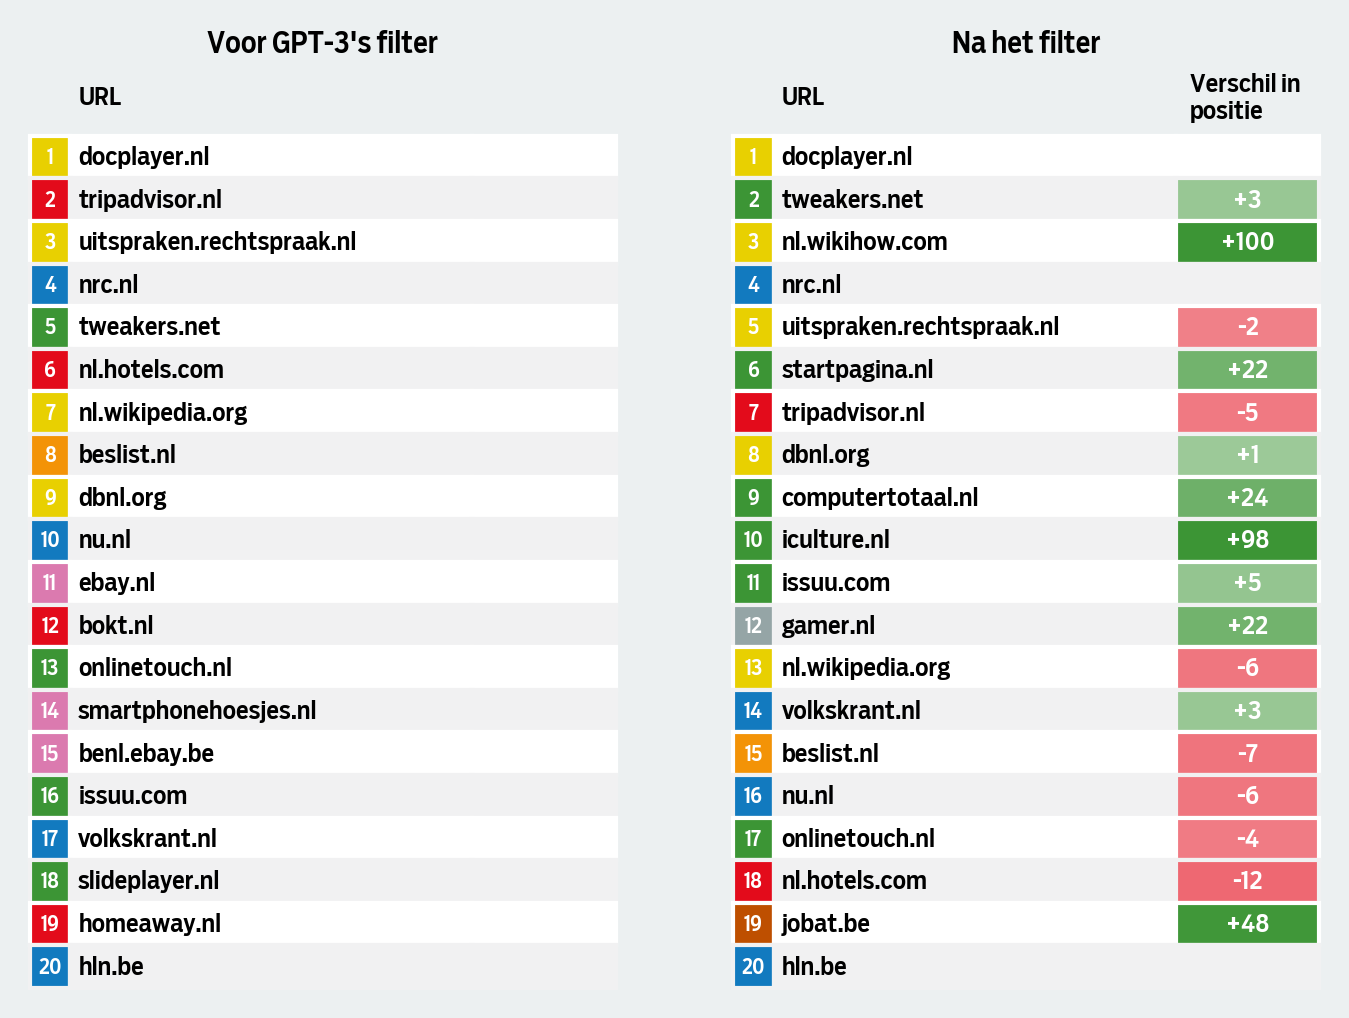

In [13]:
import six
import matplotlib as mpl

def render_mpl_table(data, colors, max_val=0, col_width=3.0, row_height=0.625, font_size=14, figsize=None,
                     header_color='#c71617', row_colors=['w', '#f1f1f2'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0, col_labels=None,
                     ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, dpi=150)
    if col_labels is None:
        col_labels = data.columns
    ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colWidths=[0.07, 0.7, 0.25],
                         colLabels=col_labels, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    done_cells = []
    
    color = '#f1f1f2'
    for k, cell in six.iteritems(mpl_table._cells):
        
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='normal', color='black', ha='left')
            cell.set_facecolor('#ECF0F1')
            cell.set_edgecolor('#ECF0F1')
            cell.set_height(0.1
                           )
            if k[1] == 1:
                cell.PAD = 0.02
            if k[1] == 3:
                cell.set_text_props(ha='center')
            continue
        elif k[0]%2:
            cell.set_facecolor(row_colors[0])
            cell.set_edgecolor(row_colors[0])
        else:
            cell.set_facecolor(row_colors[1])
            cell.set_edgecolor(row_colors[1])
        if k[1] == 3:
            cell.set_text_props(ha='center')
        else:
            cell.set_text_props(ha='left', x=-10)
        if k[1] == 0:
            cell.set_facecolor(colors[k[0] - 1])
            cell.set_text_props(ha='center', fontsize=5, c='white')
            cell.PAD = 0
        if k[1] == 1:
            cell.PAD = 0.02
        if k[1] == 2:
            text = cell._text.get_text()
            
            if int(text) == 0:
                cell.set_text_props(ha='left', c='white', alpha=0)
            elif int(text) < 0:
                cell.set_text_props(ha='center', c='white')
                color = (50 + (int(text) * - 1)) / 100 
                cell.set_facecolor(cmap_red(color))
                cell._text.set_text(text)
            elif int(text) > 0:
                cell.set_text_props(ha='center', c='white')
                color = (50 + (int(text))) / 100 
                cell.set_facecolor(cmap_green(color))
                cell._text.set_text('+' + text)
    return ax

cmap_red = mpl.colors.LinearSegmentedColormap.from_list('test', colors=['white','#e30b1b'])
cmap_green = mpl.colors.LinearSegmentedColormap.from_list('test', colors=['white','#3c9535'])

fig, axes = plt.subplots(figsize=(5.299, 3.9), dpi=150, ncols=2)

render_mpl_table(top_20[['', 'URL', 'Verschil']], 
                 colors=table_colors, font_size=6, ax=axes[0], max_val=3.6, col_labels=['', 'URL', ''])

render_mpl_table(top_20_quality[['', 'URL', 'Verschil']],
                 colors=quality_col_labels, font_size=6, ax=axes[1], max_val=3.6, col_labels=['', 'URL', 'Verschil in\npositie'])


axes[0].set_title('Voor GPT-3\'s filter', fontsize=7, weight='normal', y=0.98)
axes[1].set_title('Na het filter', fontsize=7, weight='normal', y=0.98)


set_size(fig, (4.5, 3.4), dpi=300)

fig.savefig('figures/5.pdf', dpi=300, bbox_inches='tight')

## Analyze domains

In [14]:
data['Domain'] = data.Url.apply(lambda x: x.split('.')[-1])

In [15]:
domain_count = data.Domain.value_counts()[::-1]
relative_counts = ((domain_count[::-1] / sum(domain_count[::-1])) * 100).head(10)[::-1]

In [16]:
relative_counts

ru       0.496366
info     1.124582
nu       1.224847
de       1.363423
org      1.703355
eu       1.793510
net      2.955815
be       9.384029
com     24.832109
nl      50.208534
Name: Domain, dtype: float64

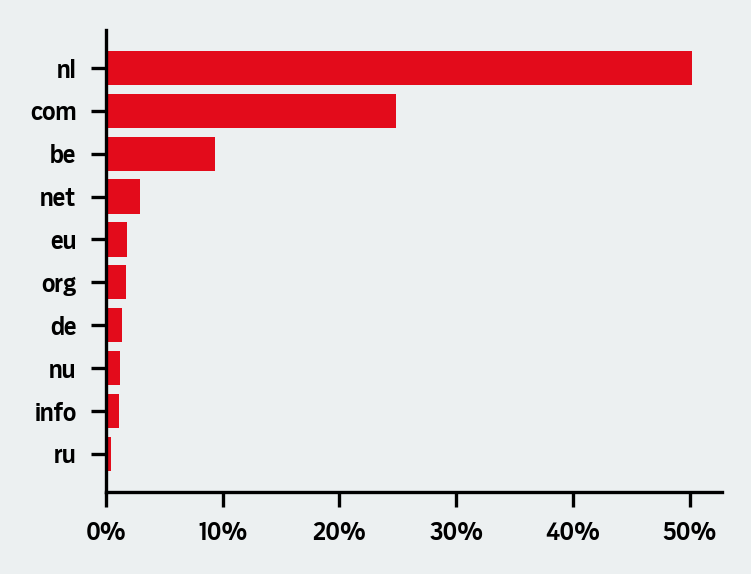

In [17]:
fig, ax = plt.subplots(figsize=(5.299 / 2, 2), dpi=150)

ax.barh(relative_counts.index, relative_counts.values)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())